In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf 
import pandas as pd
import numpy as np
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

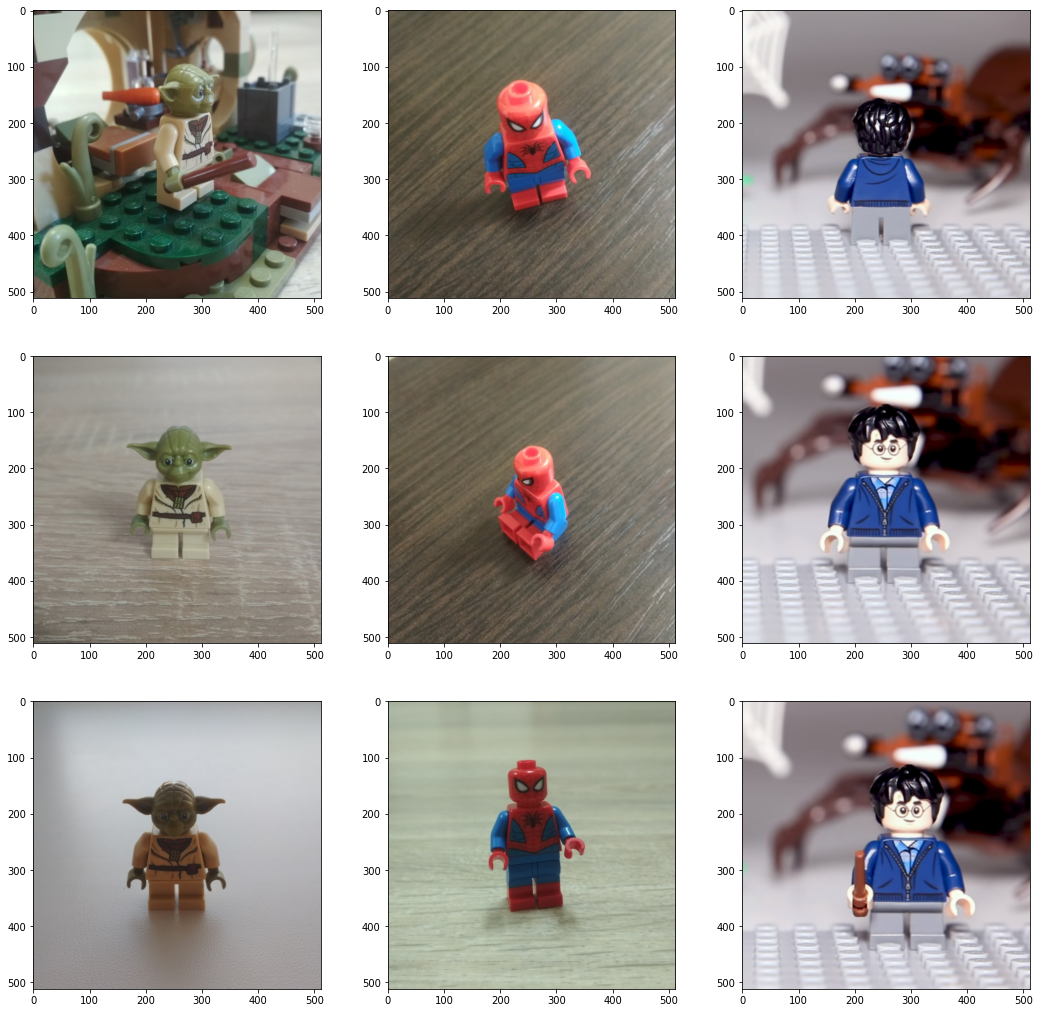

In [2]:
#Basic Visulalization of Data set---
img = [[],[],[]]
index = ['001', '002', '003']

for i in range(3):
    img[i].append(mpimg.imread('lego-minifigures-classification/star-wars/0001/' + index[i] + '.jpg'))
    img[i].append(mpimg.imread('lego-minifigures-classification/marvel/0001/' + index[i] + '.jpg'))
    img[i].append(mpimg.imread('lego-minifigures-classification/harry-potter/0001/' + index[i] + '.jpg'))

fig, axs = plt.subplots(3,3, figsize=(18,18))

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(img[i][j])

In [3]:
lego_data = pd.read_csv('lego-minifigures-classification/index.csv')
lego_data

,Unnamed: 0,path,class_id,train-valid
0,0,marvel/0001/001.jpg,1,train
1,1,marvel/0001/002.jpg,1,valid
2,2,marvel/0001/003.jpg,1,train
3,3,marvel/0001/004.jpg,1,train
4,4,marvel/0001/005.jpg,1,train
...,...,...,...,...
347,347,marvel/0017/008.jpg,31,valid
348,348,marvel/0017/009.jpg,31,valid
349,349,marvel/0017/010.jpg,31,valid
350,350,marvel/0017/011.jpg,31,valid


In [4]:
lego_train = lego_data[lego_data["train-valid"] == 'train']
lego_validation = lego_data[lego_data["train-valid"] == 'valid']

In [5]:
#Visualization---
DATASET_PATH = 'lego-minifigures-classification'

df_index = pd.read_csv(os.path.join(DATASET_PATH, 'index.csv'), index_col=0)
df_metadata = pd.read_csv(os.path.join(DATASET_PATH, 'metadata.csv'), index_col=0)
df_index = pd.merge(df_index, df_metadata[['class_id', 'minifigure_name']], on='class_id')

df_index

,path,class_id,train-valid,minifigure_name
0,marvel/0001/001.jpg,1,train,SPIDER-MAN
1,marvel/0001/002.jpg,1,valid,SPIDER-MAN
2,marvel/0001/003.jpg,1,train,SPIDER-MAN
3,marvel/0001/004.jpg,1,train,SPIDER-MAN
4,marvel/0001/005.jpg,1,train,SPIDER-MAN
...,...,...,...,...
347,marvel/0017/008.jpg,31,valid,IRON MAN MK 50
348,marvel/0017/009.jpg,31,valid,IRON MAN MK 50
349,marvel/0017/010.jpg,31,valid,IRON MAN MK 50
350,marvel/0017/011.jpg,31,valid,IRON MAN MK 50


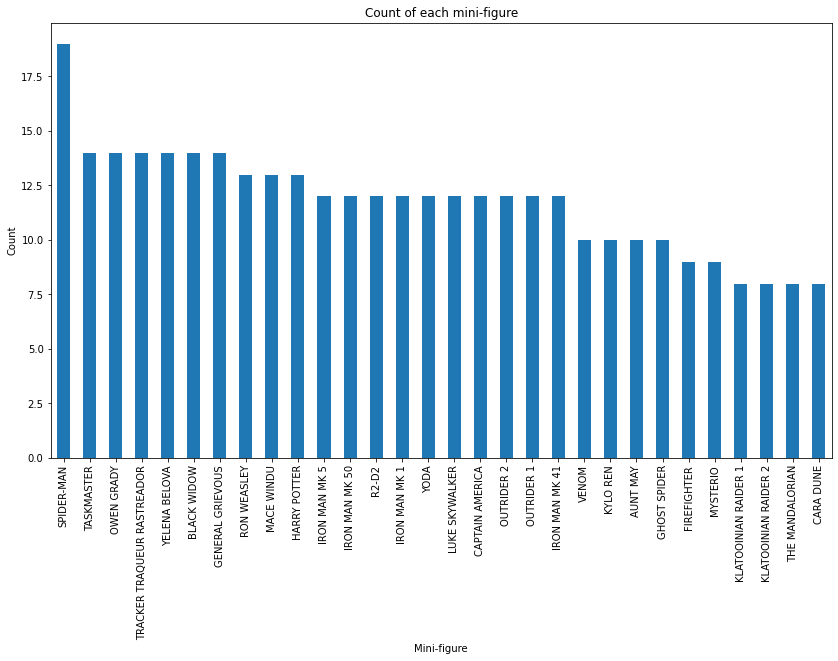

In [6]:
ax = df_index['minifigure_name'].value_counts().plot(
    kind='bar',
    figsize=(14,8),
    title="Count of each mini-figure",
)

ax.set_xlabel("Mini-figure")
ax.set_ylabel("Count")
plt.show()

In [7]:
lego_train

,Unnamed: 0,path,class_id,train-valid
0,0,marvel/0001/001.jpg,1,train
2,2,marvel/0001/003.jpg,1,train
3,3,marvel/0001/004.jpg,1,train
4,4,marvel/0001/005.jpg,1,train
6,6,marvel/0001/007.jpg,1,train
...,...,...,...,...
341,341,marvel/0017/002.jpg,31,train
342,342,marvel/0017/003.jpg,31,train
343,343,marvel/0017/004.jpg,31,train
344,344,marvel/0017/005.jpg,31,train


In [8]:
base_model = tf.keras.applications.DenseNet121()
my_layer = Dropout(0.5)(base_model.layers[-2].output)
number_of_classes = len(lego_data['class_id'].unique())
my_outputs = Dense(number_of_classes, activation="softmax")(my_layer)
model = Model(base_model.input, my_outputs)

In [9]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [11]:
X_train = np.zeros((lego_train.shape[0], 512, 512, 3))

for i in range(lego_train.shape[0]):
    img = cv2.imread('lego-minifigures-classification/' + lego_train["path"].values[i])
    img = cv2.resize(img, dsize=(512,512)) # resize in case if image was not 512x512 pixels
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_train[i] = img/255

Y_train = np.array(lego_train["class_id"])-1

X_valid = np.zeros((lego_validation.shape[0], 512, 512, 3))

In [12]:
for i in range(lego_validation.shape[0]):
    img = cv2.imread('lego-minifigures-classification/' + lego_validation["path"].values[i])
    img = cv2.resize(img, dsize=(512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_valid[i] = img/255

Y_valid = np.array(lego_validation["class_id"])-1

In [13]:
Y_train

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  7,  7,  8,  8,  4,  5,  6,  9,  9,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11,
       12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20,
       21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23,
       23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 26, 26,
       26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28,
       29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30], dtype=int64)

In [14]:
chpoint = ModelCheckpoint(filepath='model.h5', monitor="val_accuracy", save_best_only=True, verbose=1)

In [15]:
model.fit(
    X_train, 
    Y_train, 
    epochs=5, 
    validation_data=(X_valid, Y_valid), 
    shuffle=True, 
    batch_size=4, 
    callbacks=chpoint
)

Epoch 1/5
46/46 [==============================] - ETA: 0s - loss: 4.0735 - accuracy: 0.0330 WARNING:tensorflow:Model was constructed with shape (None, 224, 224, 3) for input Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32), but it was called on an input with incompatible shape (None, 512, 512, 3).

Epoch 00001: val_accuracy improved from -inf to 0.12353, saving model to model.h5
46/46 [==============================] - 747s 16s/step - loss: 4.0735 - accuracy: 0.0330 - val_loss: 3.3274 - val_accuracy: 0.1235
Epoch 2/5
46/46 [==============================] - ETA: 0s - loss: 3.2466 - accuracy: 0.1319 
Epoch 00002: val_accuracy improved from 0.12353 to 0.28824, saving model to model.h5
46/46 [==============================] - 656s 14s/step - loss: 3.2466 - accuracy: 0.1319 - val_loss: 2.7832 - val_accuracy: 0.2882
Epoch 3/5
46/46 [==============================] - ETA: 0s - loss: 2.4045 - accuracy: 0.3846 
Epoch 00003: val_accuracy improved from 0.28824 to 0.43529, saving mo

In [16]:
model = load_model("model.h5")

In [17]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

Class:	27	Minifigure:	TRACKER TRAQUEUR RASTREADOR


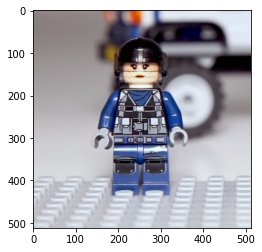

In [18]:
img = cv2.imread('lego-minifigures-classification/jurassic-world/0002/005.jpg') 
#img = cv2.resize(img, dsize=(512,512)) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255 

plt.imshow(img)  

img = np.reshape(img, (1, 512, 512, 3)) 

ans = model.predict(img).argmax() 
ans = ans+1 
metadata = pd.read_csv('lego-minifigures-classification/metadata.csv') 

minifigure = metadata["minifigure_name"][metadata["class_id"] == ans].iloc[0] 
print(f"Class:\t{ans}\tMinifigure:\t{minifigure}")

Class:	12	Minifigure:	CARA DUNE
Class:	27	Minifigure:	TRACKER TRAQUEUR RASTREADOR
Class:	27	Minifigure:	TRACKER TRAQUEUR RASTREADOR
Class:	27	Minifigure:	TRACKER TRAQUEUR RASTREADOR
Class:	27	Minifigure:	TRACKER TRAQUEUR RASTREADOR
Class:	27	Minifigure:	TRACKER TRAQUEUR RASTREADOR
Class:	27	Minifigure:	TRACKER TRAQUEUR RASTREADOR
Class:	27	Minifigure:	TRACKER TRAQUEUR RASTREADOR


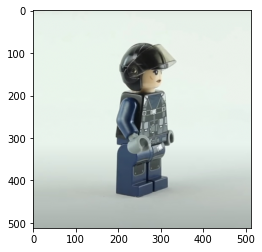

In [22]:
idx=['001', '002', '003','004','005','006','007','008']


for i in idx:
    img = cv2.imread('lego-minifigures-classification/jurassic-world/0002/'+i+'.jpg') 
    #img = cv2.resize(img, dsize=(512,512)) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255 
    plt.imshow(img)  

    img = np.reshape(img, (1, 512, 512, 3)) 

    ans = model.predict(img).argmax() 
    ans = ans+1  
    metadata = pd.read_csv('lego-minifigures-classification/metadata.csv') 

    minifigure = metadata["minifigure_name"][metadata["class_id"] == ans].iloc[0] 
    print(f"Class:\t{ans}\tMinifigure:\t{minifigure}")

In [ ]:
lego-minifigures-classification/marvel/0001/' + index[i] + '.jpg'))

Class:	15	Minifigure:	MYSTERIO
Class:	15	Minifigure:	MYSTERIO
Class:	18	Minifigure:	HARRY POTTER
Class:	15	Minifigure:	MYSTERIO
Class:	15	Minifigure:	MYSTERIO
Class:	15	Minifigure:	MYSTERIO
Class:	18	Minifigure:	HARRY POTTER
Class:	15	Minifigure:	MYSTERIO


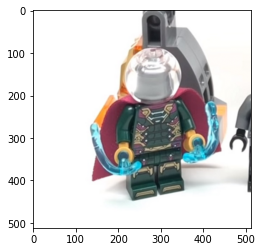

In [27]:
idx=['001', '002', '003','004','005','006','007','008']


for i in idx:
    img = cv2.imread('lego-minifigures-classification/marvel/0005/' + i + '.jpg')
    #img = cv2.resize(img, dsize=(512,512)) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255 
    plt.imshow(img)  

    img = np.reshape(img, (1, 512, 512, 3))  

    ans = model.predict(img).argmax() 
    ans = ans+1 
    metadata = pd.read_csv('lego-minifigures-classification/metadata.csv') 

    minifigure = metadata["minifigure_name"][metadata["class_id"] == ans].iloc[0] 
    print(f"Class:\t{ans}\tMinifigure:\t{minifigure}")

Class:	7	Minifigure:	R2-D2
Class:	7	Minifigure:	R2-D2
Class:	7	Minifigure:	R2-D2
Class:	7	Minifigure:	R2-D2
Class:	7	Minifigure:	R2-D2
Class:	7	Minifigure:	R2-D2
Class:	7	Minifigure:	R2-D2
Class:	7	Minifigure:	R2-D2


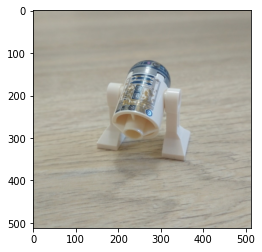

In [30]:
idx=['001', '002', '003','004','005','006','007','008']


for i in idx:
    img = cv2.imread('lego-minifigures-classification/star-wars/0003/' + i + '.jpg') 
    #img = cv2.resize(img, dsize=(512,512)) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
    plt.imshow(img) 

    img = np.reshape(img, (1, 512, 512, 3))

    ans = model.predict(img).argmax()
    ans = ans+1 
    metadata = pd.read_csv('lego-minifigures-classification/metadata.csv') 

    minifigure = metadata["minifigure_name"][metadata["class_id"] == ans].iloc[0] 
    print(f"Class:\t{ans}\tMinifigure:\t{minifigure}")